# Customer Segmentation - Clustering_K-Mean

***This project aims to segment customers based on their purchasing behavior using RFM (Recency, Frequency, Monetary) analysis and K-Means clustering.***

## 1. Loading Libraries

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import missingno as msno

from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler


from sklearn.cluster import KMeans,MeanShift, DBSCAN, estimate_bandwidth
from sklearn.metrics import silhouette_score


In [42]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable


In [43]:
df_=pd.read_excel('archive/Online Retail.xlsx')

In [44]:
df_.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 2. Understand the Data

**Lets Understand The Data - Online Retail INformation**
* "INVOICENO" -> This column stand for every unique identity , generate when every  sales transcation complete.

* "STOCKCODE" -> unique identifier for every each item on transaction.

* "DESCRIPTION" -> Name of Every product sales in Transaction.

* "QUANTITY" -> No of product/quantity  sales in every transaction .

* "INVOICEDATE" -> Date of transaction.

* "UnitPrice" -> Per product price  in evry quantity of transaction.

* "CUSTOMERID" -> iTS A UNIQUE ID OF every customer who made a purchase.

* "country" -> Its Address of Customer ID.

In [45]:
df_.shape

(541909, 8)

In [46]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [47]:
df_.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


### 3 Data Cleaning

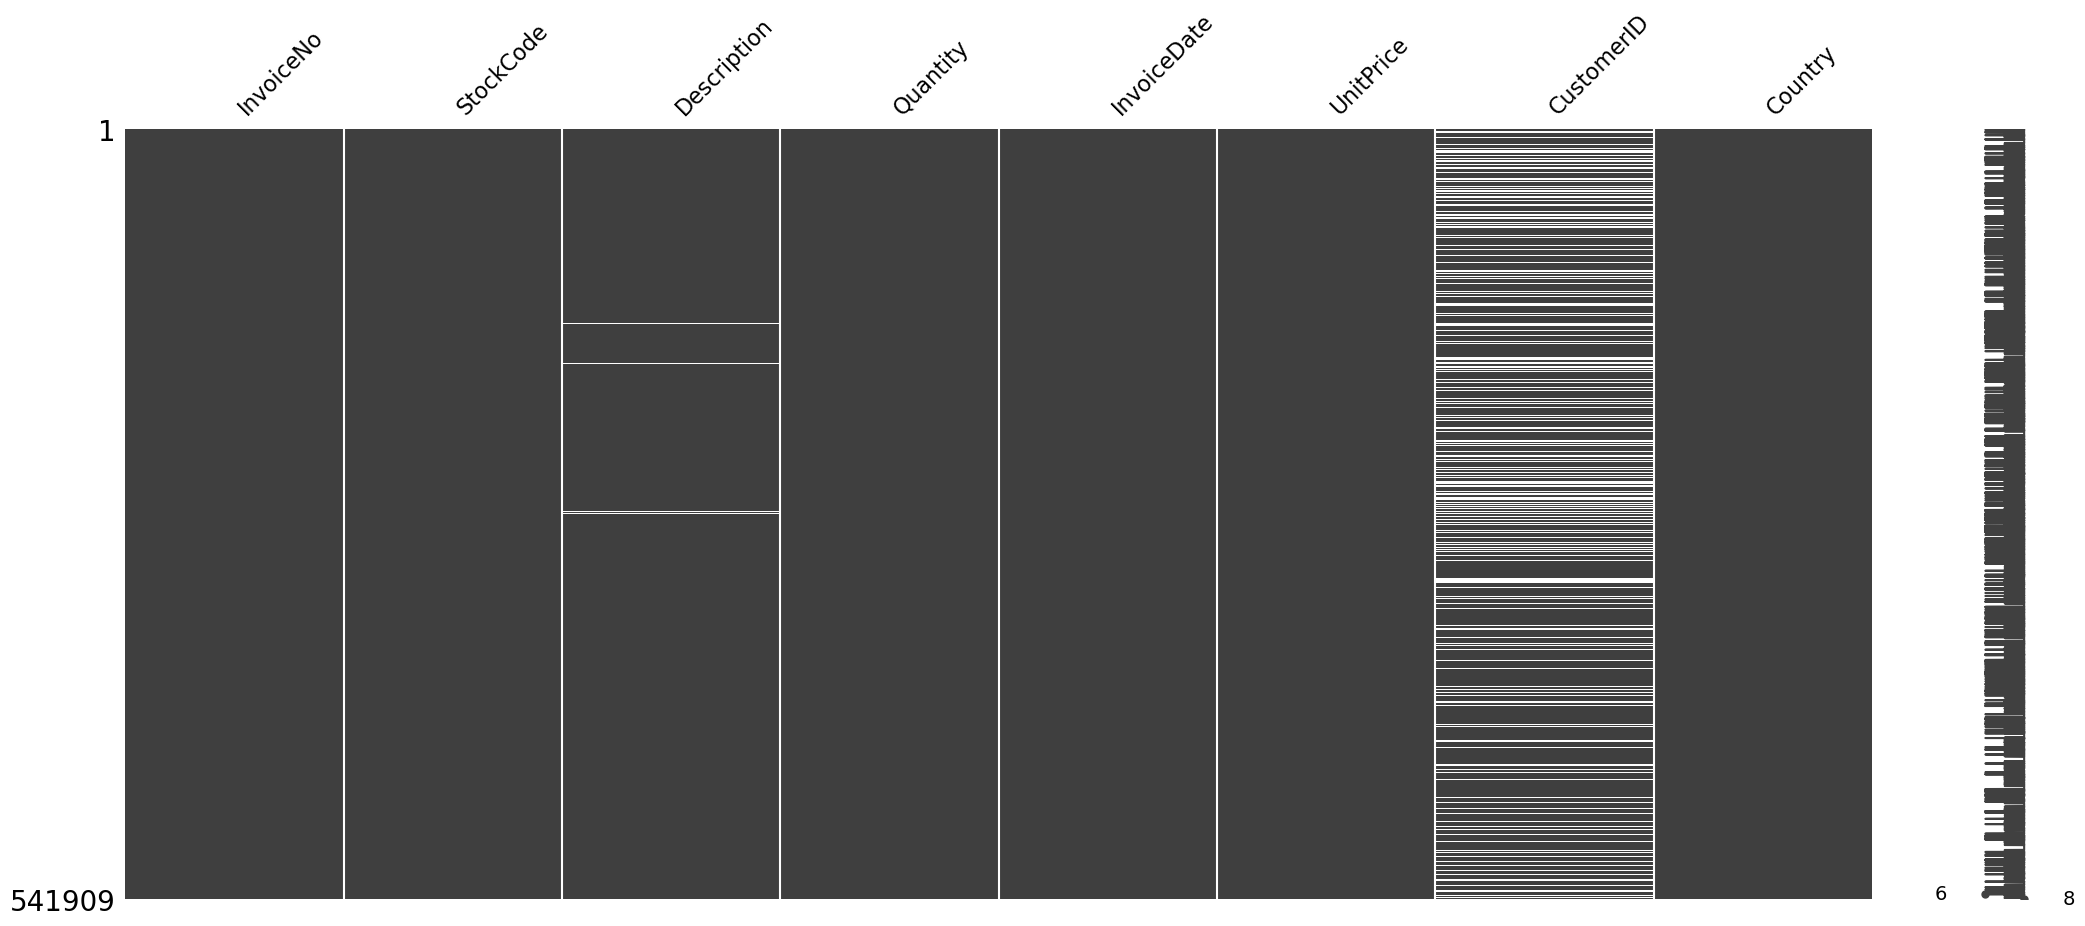

In [48]:
msno.matrix(df_)
plt.show()

* CustomerID have heavy horizontal white line that shows missing Values. 
* Description also have some misiing value.

**Now Calculate exact no of missing Values.**

In [49]:
df_.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [50]:
df=df_.copy()

* CustomerID is unique iD of person so we cant link these **missing** ID to any other Person , to calculate their total spend(Monetary) ,or visit(frequency) , impact create Fake Clusters so we work on clone file

In [51]:
df.dropna(subset=["CustomerID"],inplace=True) 


df["Description"]= df["Description"].fillna('Unknown Item')

* **Drop** customerID who have mising values

* **filling** description  with **Unknown** Because it have very less no of missing values so make  no impact on Model. 

In [52]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

* Now There are No missing Values 

In [53]:
df["CustomerID"] =df["CustomerID"].astype(int)                  # Customer ID  to be a integer 

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int32         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 26.4+ MB


### 4 Feature Engineering(RFM)

Calculating total amount spend by customer and add as an column ,    Amount=Quantity * UnitPrice

In [55]:
df["TotalAmount"]=df["Quantity"]*df["UnitPrice"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [56]:
Monetary=df.groupby('CustomerID')['TotalAmount'].sum().reset_index()
Monetary.rename(columns={'TotalAmount' : 'Monetary'} ,inplace=True)

Monetary.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


Calculating Frequency W.R.T  CustomerID  - Count of InvoiceNo as per Customer

In [57]:
frequency=df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency.rename(columns={'InvoiceNo' : 'Frequency'} ,inplace=True)
frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [58]:

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])                                        #Converts InvoiceDate Column  string-> datetime format 

To find **Recency** 
* Need a refrence Date ,  most recent date in the Dataset and add 1 day to ensure no 0-day result.
* And then find the max() of INvoiceDate of Customer. 

In [59]:
snapshot_date=df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [60]:
df_recency=df.groupby('CustomerID')['InvoiceDate'].max().reset_index()

In [61]:
df_recency['Recency']=(snapshot_date-df_recency['InvoiceDate']).dt.days

In [62]:
df_recency=df_recency[['CustomerID', 'Recency']]
df_recency.head()

,CustomerID,Recency
0,12346,326
1,12347,2
2,12348,75
3,12349,19
4,12350,310


**Mereg r,f,m**

In [63]:
rfm=df_recency.merge(Monetary ,on="CustomerID").merge(frequency,on="CustomerID")
rfm.head()

,CustomerID,Recency,Monetary,Frequency
0,12346,326,0.00,2
1,12347,2,4310.00,182
2,12348,75,1797.24,31
3,12349,19,1757.55,73
4,12350,310,334.40,17


In [64]:
rfm.info()

rfm.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4372 non-null   int32  
 1   Recency     4372 non-null   int64  
 2   Monetary    4372 non-null   float64
 3   Frequency   4372 non-null   int64  
dtypes: float64(1), int32(1), int64(2)
memory usage: 119.7 KB


CustomerID    0
Recency       0
Monetary      0
Frequency     0
dtype: int64

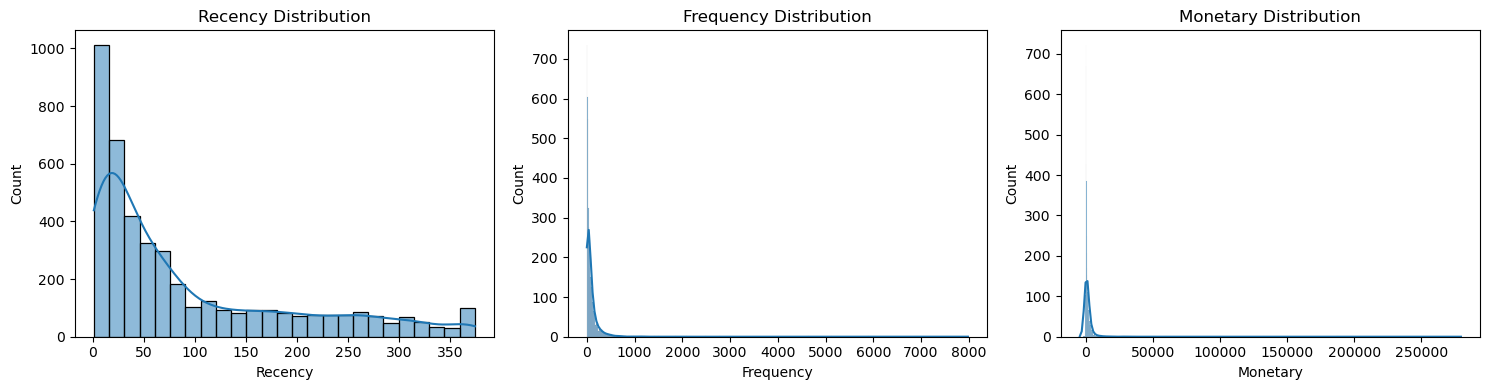

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(rfm["Recency"], kde=True, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(rfm["Frequency"], kde=True, ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.histplot(rfm["Monetary"], kde=True, ax=axes[2])
axes[2].set_title("Monetary Distribution")

plt.tight_layout()
plt.show()


**Insights**
* **Recency Distribution :** Most Customers have interacted recently (peak near 0) , But there is fast decline , only a small positive near 350 . very high risk customers are not purchasing from nearly a year 

* **Frequency And Monetary Distribution :** The majority of customers have low transaction and spenditure(Amount) , only a tiny where is high value at 0.
* Both have very large scale of Distribution going up to  8000 and 250000 respectively(rigth skewed Data) . 
* but that super point at 0 pull the cluster center from the avg. Customer . when train model

***For Preventing them to distribute Equally(or Remove outliers) USE  **LOG TRANSFORMATION** :***

* Its compress the long tail and make Distribution more Normal

In [66]:
rfm_log=rfm[['Recency' ,'Frequency' ,'Monetary']].apply(np.log1p , axis=1)

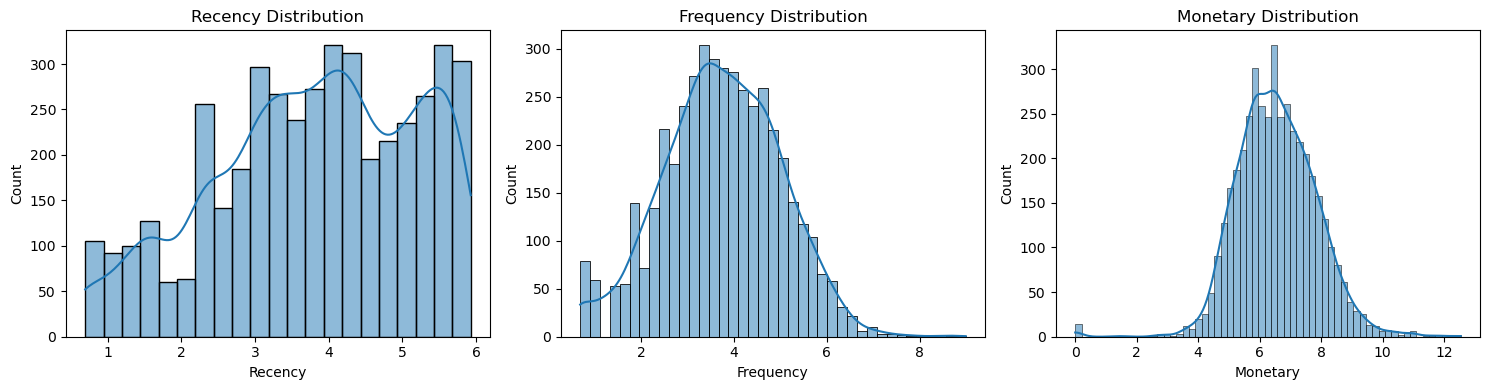

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(rfm_log["Recency"], kde=True, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(rfm_log["Frequency"], kde=True, ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.histplot(rfm_log["Monetary"], kde=True, ax=axes[2])
axes[2].set_title("Monetary Distribution")

plt.tight_layout()
plt.show()


**Improved Distribution**
* Monetary and Frequency :  Now transfromed from long skews to perfectly curves (Normal Distribution ) Ideal for k-Means Algorthim 
* Recency : Its also spread out from[1,6] rather then peak at only 0.

### 5 Data Preprocessing

* To ensure RFM contributes equally to the Segmentation , So Here we Apply  ***STANDARDIZATION(Z-SCORE normalization)*** This will center all three at a mean=0 , deviation=1

In [68]:
rfm_log_clean = rfm_log.dropna()


scaler=StandardScaler()

rfm_scaled=scaler.fit_transform(rfm_log_clean)
rfm_scaled.shape


(4331, 3)

In [69]:
rfm_scaled=pd.DataFrame(rfm_scaled,index=rfm_log_clean.index,columns=rfm_log_clean.columns)
rfm_scaled.head()

,Recency,Frequency,Monetary
0,1.472026,-2.142512,-5.053011
1,-1.970891,1.160514,1.401764
2,0.401119,-0.240563,0.727388
3,-0.578620,0.433022,0.710174
4,1.435209,-0.702860,-0.567774


### 6. Build Model

***k-Mean Clustering***

**Is a centroid -based unsperwised algorthim. It works by minimizing the within the cluster sum of square distance also known as **(Inertia)**.**

* Randomly select k point as intial centeroid
* Assign Each customer(data point) to the nearst centroid based on Distance.
* Calculate the mean of all points in a cluster and moves the centroid to that mean.
* Repeat until centroid stop moving.

**To decide the numbers of k cluster k have need two things.**
* 1. How tight pack cluster **(Elbow Method)**
* 2. How well seperated They are from each other **(Silhouette Score)**

In [70]:
SSD=[]
for k in range(2,9):
 kmeans=KMeans(n_clusters=k,random_state=42)
 kmeans.fit(rfm_scaled)
 SSD.append(kmeans.inertia_)

In [71]:
for k in range(2,9):
  kmeans=KMeans(n_clusters=k,random_state=42)
  labels=kmeans.fit_predict(rfm_scaled)


  print(k,silhouette_score(rfm_scaled,labels))


2 0.39882661386763985
3 0.3046485968925226
4 0.3096454826069473
5 0.2787882870709417
6 0.272558318045047
7 0.26449764204334847
8 0.25769275950595444


***Choose k=? for final model***   Silhouette Range -1 to 1

* k=2 have highest silhouette Score rather than anyone
* Instead of using k=2 we use k=4 
**Reason**
* By technically k=2 is good , but it usually split customers into low and high spenders **Which isn't helpfull for marketing.**
* k=3 drops silhouette score
* k=4 shows slightly increase back. In clustering if value goes again up after a drop it suggest that the value is genuine.


Its divide into 4 type of Customers 

* 1. Best Customers - High (frequnecy , spend ,recent)
* 2. Loyal/New      - High (frequency , recent ) but low spend
* 3. Risk_ C        - High spend but low recent
* 4. Low value Customer - low(recent, frequency ,spend)

In [72]:
# Final model
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_log_clean['Cluster_Id'] = kmeans.fit_predict(rfm_scaled)

C:\Users\hp\AppData\Local\Temp\ipykernel_1620\432780770.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
rfm_log_clean['Cluster_Id'].value_counts()


Cluster_Id
1    1360
2    1235
3     888
0     848
Name: count, dtype: int64

In [74]:
cluster_profile = rfm_log_clean.groupby('Cluster_Id')[['Recency','Frequency','Monetary']].mean()
cluster_profile.head()


,Recency,Frequency,Monetary
Cluster_Id,,,
0,2.700730,3.449816,6.145863
1,5.001842,2.538038,5.366392
2,4.315674,4.218496,6.971662
3,2.214682,5.315073,8.169403


**Insight About Cluster/group of customer**
* Cluster 3 :- (888) Customers across them high(monetary ,frequency) and low recency it mean That are **Excellemt Customers**.
* Cluster 2 :- (1235) one of biggest cluster High(Frequency ,Monetary) but mediun recency , **loyal customers** but they have not visit in a while
* Cluster 1 :- (1360) Biggest Cluster btwn them Low(Frequency ,Monetary) high receny , At **Risk Customers** spent little ,shoped rarely,seen in a long time.
* Cluster 0 :- (848) smallest group Low(recency ,frequnecy ,Monetary) , **Recent/New** customer who spend low 

### Now see all them BY Visualization-> Variation of Receny, Monetary and Frequency According to Cluster

In [75]:

fig = px.box(rfm_log_clean, x='Cluster_Id', y='Monetary',
             title="Cluster W.R.T Monetary",
             labels={'Cluster_Id': 'Cluster ID', 'Amount': 'Amount'},
             color='Cluster_Id')

fig.update_layout(
    xaxis=dict(title="Cluster ID"),
    yaxis=dict(title="Amount"),
    showlegend=False,
    width=800,
    height=600
)
fig.show()

* Cluster 3 :- have spend more amount caompare to opthers
* Cluster 2 :- IS also spend best
* Clsuter 1 :- Lowest Expenduture rate

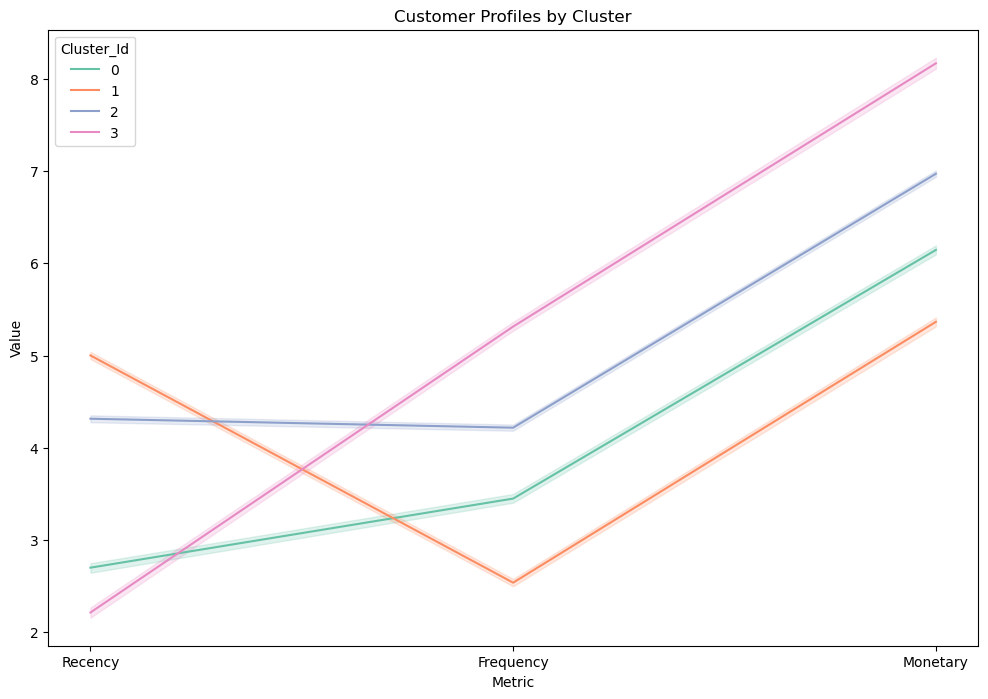

In [76]:
plt.figure(figsize=(12,8))
# Melt the data for a snake plot
rfm_melted = pd.melt(rfm_log_clean.reset_index(), 
                    id_vars=['Cluster_Id'], 
                    value_vars=['Recency', 'Frequency', 'Monetary'], 
                    var_name='Metric', 
                    value_name='Value')

sns.lineplot(x='Metric', y='Value', hue='Cluster_Id', data=rfm_melted, palette='Set2')
plt.title('Customer Profiles by Cluster')
plt.show()

* Pink Line ->  Staright line these are Champion Customers

* Golden Line ->Perfct V shape high Risk Churn Custoemrs

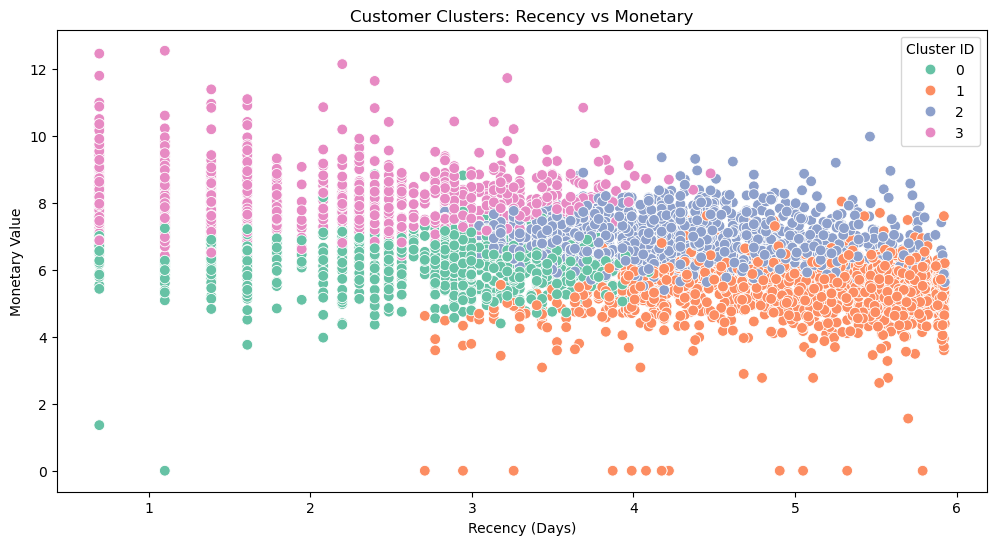

In [77]:
plt.figure(figsize=(12,6))

sns.scatterplot(
    data=rfm_log_clean,
    x="Recency",
    y="Monetary",
    hue="Cluster_Id",
    palette="Set2",
    s=60
)
 
plt.title("Customer Clusters: Recency vs Monetary")
plt.xlabel("Recency (Days)")
plt.ylabel("Monetary Value")
plt.legend(title="Cluster ID")
plt.show()

In [78]:
fig = px.box(rfm_log_clean, x='Cluster_Id', y='Frequency',
             title="Cluster Id vs Frequency Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

* GROUP 3 :- HigH  fREQUENCY THEY Shop more as compare to others 
* Group 1 :  lowest Frequency rate

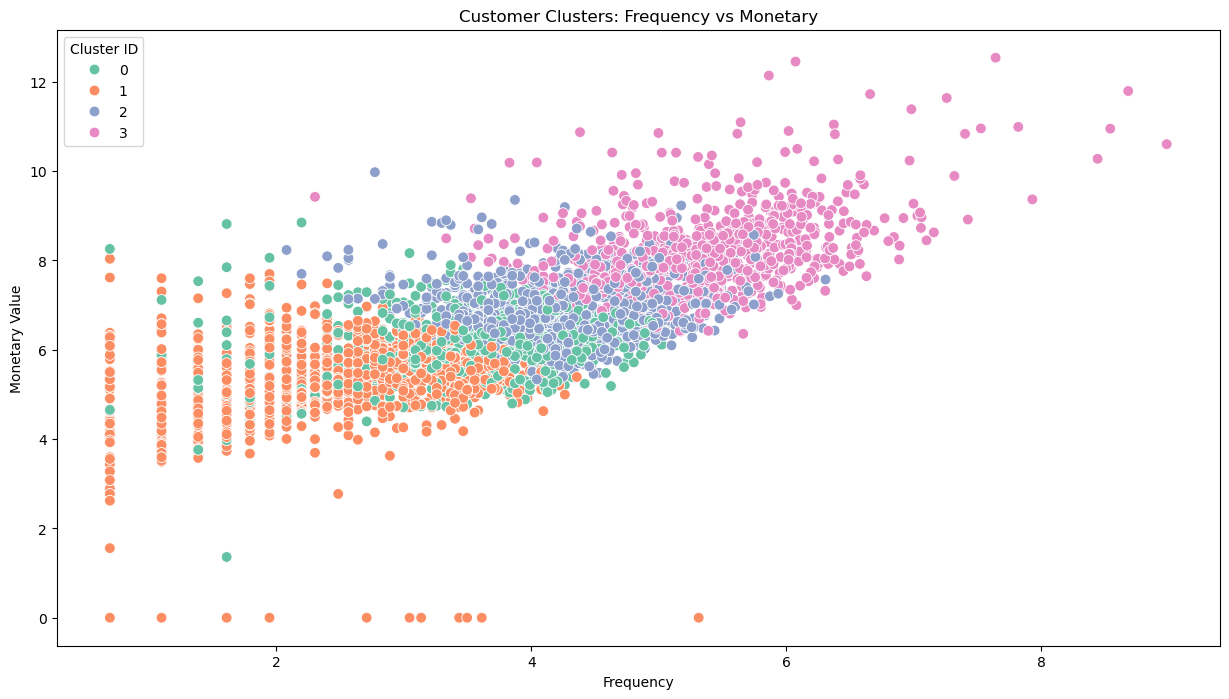

In [79]:
plt.figure(figsize=(15,8))

sns.scatterplot(
    data=rfm_log_clean,
    x="Frequency",
    y="Monetary",
    hue="Cluster_Id",
    palette="Set2",
    s=60
)

plt.title("Customer Clusters: Frequency vs Monetary")
plt.xlabel("Frequency")
plt.ylabel("Monetary Value")
plt.legend(title="Cluster ID")
plt.show()

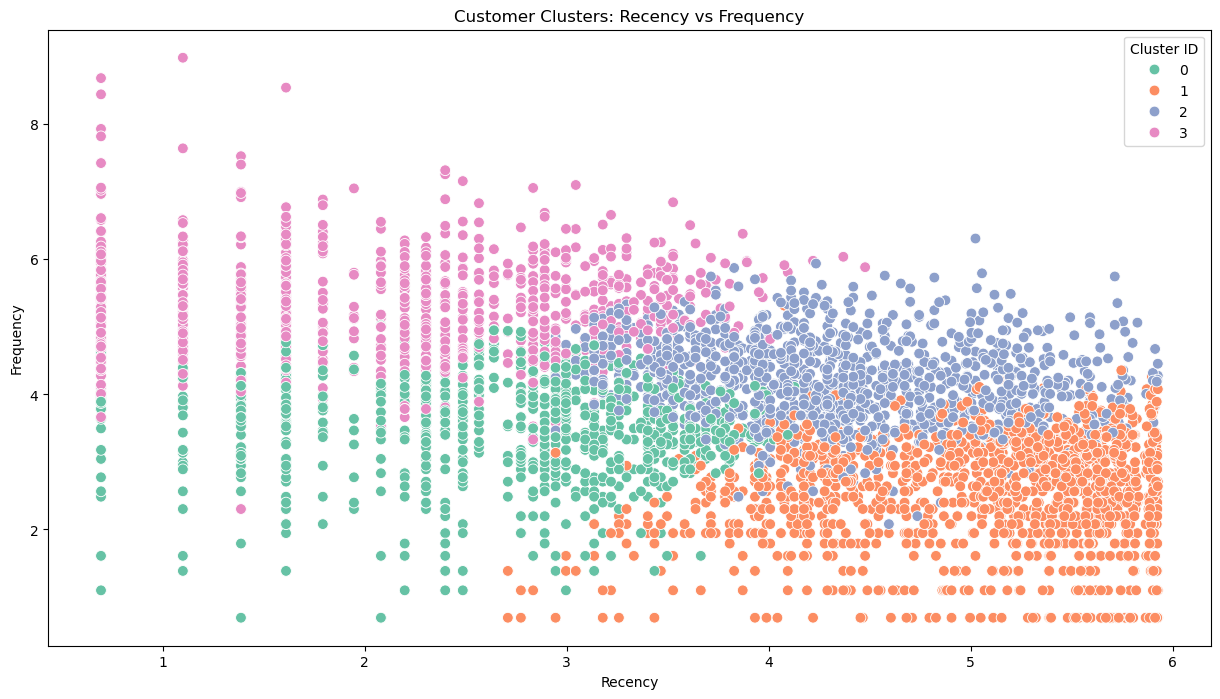

In [80]:
plt.figure(figsize=(15,8))

sns.scatterplot(
    data=rfm_log_clean,
    x="Recency",
    y="Frequency",
    hue="Cluster_Id",
    palette="Set2",
    s=60
)

plt.title("Customer Clusters: Recency vs Frequency")
plt.xlabel("Recency")
plt.ylabel("Frequency")
plt.legend(title="Cluster ID")
plt.show()

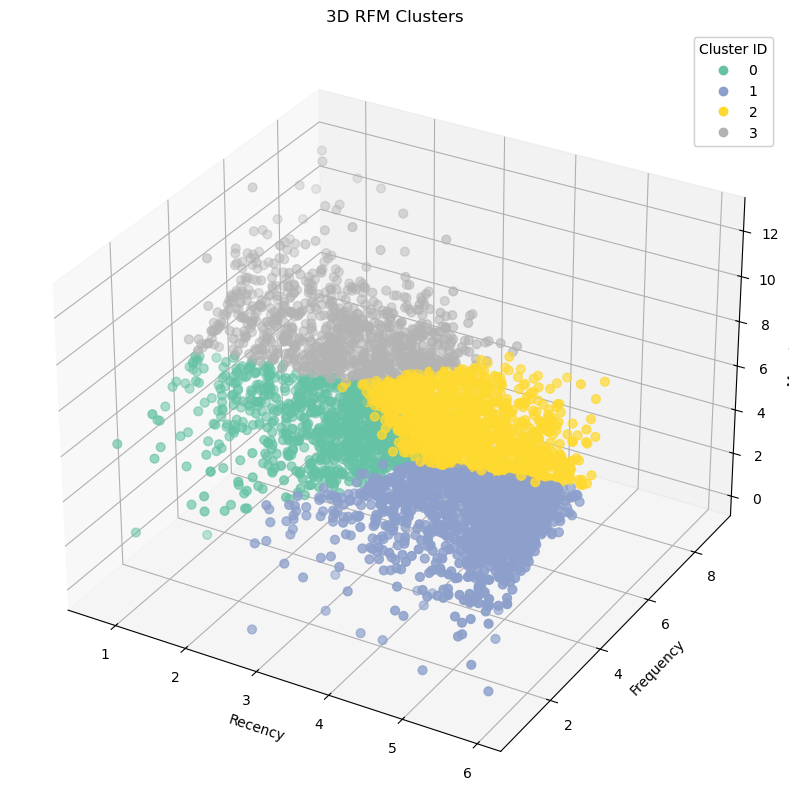

In [81]:

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm_log_clean["Recency"],
    rfm_log_clean["Frequency"],
    rfm_log_clean["Monetary"],
    c=rfm_log_clean["Cluster_Id"],
    cmap="Set2",
    s=40
)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D RFM Clusters")

legend = ax.legend(*scatter.legend_elements(), title="Cluster ID")
ax.add_artist(legend)

plt.show()

This is Final Corelation btm the 4 Cluster as you see

Final Insights

* Performed customer segmentation using RFM analysis and K-Means clustering

* Identified high-value customers with low recency, high frequency, and high monetary value

* Detected at-risk customers showing high recency and declining purchase behavior

* Recognized low-value customers with infrequent and low spending patterns

* Clustering revealed clear behavioral differences among customer groups

* Insights enable targeted marketing and personalized strategies

* Helps improve customer retention and revenue optimizatio